## Import libraries:

In [1]:
from imports import *

**voy a intentar usar la variable flash_time y la variable flash_total_pe**

In [2]:
file_path = '/data/vidales/opana_tree_combined_v0411_both.root'
file = uproot.open(file_path)
optree = file['opanatree']['OpAnaTree'] # Tree con número de fotoelectrones
print("Keys in optree:", optree.keys())

Keys in optree: ['eventID', 'runID', 'subrunID', 'nuvX', 'nuvY', 'nuvZ', 'nuvT', 'nuvE', 'stepX', 'stepY', 'stepZ', 'stepT', 'dE', 'energydep', 'energydepX', 'energydepY', 'energydepZ', 'E', 'StartPx', 'StartPy', 'StartPz', 'EndPx', 'EndPy', 'EndPz', 'process', 'trackID', 'motherID', 'PDGcode', 'InTimeCosmics', 'InTimeCosmicsTime', 'dEtpc', 'dEpromx', 'dEpromy', 'dEpromz', 'dEspreadx', 'dEspready', 'dEspreadz', 'dElowedges', 'dEmaxedges', 'nopflash', 'flash_id', 'flash_time', 'flash_total_pe', 'flash_pe_v', 'flash_tpc', 'flash_y', 'flash_yerr', 'flash_z', 'flash_zerr', 'flash_x', 'flash_xerr', 'flash_ophit_time', 'flash_ophit_risetime', 'flash_ophit_starttime', 'flash_ophit_amp', 'flash_ophit_area', 'flash_ophit_width', 'flash_ophit_pe', 'flash_ophit_ch']


In [3]:
# Load variables to be predicted and associated data in a single step
nuvZ, nuvT, flash_tpc, flash_time, flash_total_pe = (optree[key].array() for key in ['nuvZ', 'nuvT', 'flash_tpc', 'flash_time', 'flash_total_pe'])

In [4]:
print("nuvT:", nuvT)
print("nuvZ:", nuvZ)
print("flash_time:", flash_time)
print("flash_total_pe:", flash_total_pe)
print("flash_tpc:", flash_tpc)

nuvT: [[1.83e+03], [1.85e+03], [592, 1.47e+03], [520], ..., [889], [1.35e+03], [642]]
nuvZ: [[108], [141], [450, 488], [-0.653], [182], ..., [332], [249], [262], [222]]
flash_time: [[1.83, 1.89], [1.85, 1.9], ..., [1.35, ...], [0.942, 0.644, 0.924, 0.684]]
flash_total_pe: [[4.25e+04, 2.39e+03], [7.32e+04, ...], ..., [8.01e+03, 7.11e+04, 392, 2.7e+03]]
flash_tpc: [[0, 2], [0, 2], [0, 1, 3], [0, 2], ..., [0, ...], [1, 3], [0, 2], [0, 1, 2, 3]]


**Filter events with more than one neutrino**

In [6]:
# Assuming all variables are awkward arrays
nuvT = nuvT[ak.num(nuvZ) == 1]
nuvZ = nuvZ[ak.num(nuvZ) == 1]
flash_time = flash_time[ak.num(nuvZ) == 1]
flash_total_pe = flash_total_pe[ak.num(nuvZ) == 1]
flash_tpc = flash_tpc[ak.num(nuvZ) == 1]

# Now all the variables are filtered and contain only subarrays with length 1 in nuvT.

**Filter events with no flash**

In [8]:
nuvT = nuvT[ak.num(flash_time) != 0]
nuvZ = nuvZ[ak.num(flash_time) != 0]
flash_time = flash_time[ak.num(flash_time) != 0]
flash_total_pe = flash_total_pe[ak.num(flash_time) != 0]
flash_tpc = flash_tpc[ak.num(flash_time) != 0]

In [9]:
print(ak.sum(ak.num(nuvT)))
print(ak.sum(ak.num(nuvZ)))

29007
29007


**Correction**

In [10]:
ToF_inside = ak.flatten(nuvZ) / 3E10 *1E9
ToF_outside = 110 / 3E8 * 1E9
bunch_separation = 19
print("ToF_inside:",ToF_inside, "ns")
print(f"ToF_outside {ToF_outside:.0f} ns")
print(f"bunch_separation: {bunch_separation:.0f} ns")

ToF_inside: [3.61, 4.69, -0.0218, 6.06, 4.48, 15.9, ..., 0.267, 6.22, 11.1, 8.32, 8.73, 7.4] ns
ToF_outside 367 ns
bunch_separation: 19 ns


In [27]:
#ToF outside solo añade un shift global. ToF inside no se le mete a hit_t porque debe intentar predecirlo. Hit_t no sé si tiene sentido hacer el módulo 19 pero creo que no.
#hit_nuvT_c= np.mod(hit_nuvT - ToF_outside - ToF_inside, bunch_separation)
nuvT_c= nuvT - ToF_inside - ToF_outside
nuvT_c_bunch = np.mod(nuvT_c + 7, bunch_separation) # +7 is to center the distribution
flash_time_c = flash_time*1000 - ToF_inside - ToF_outside
flash_time_c_bunch  = flash_time*1000 - ToF_inside - ToF_outside - ak.flatten(nuvT_c)

In [36]:
print(nuvT_c)

[[1.46e+03], [1.48e+03], [153], [643], ..., [173], [514], [971], [268]]


In [41]:
print(flash_time*1000  - ToF_outside - ToF_inside)
print((flash_time*1000  - ToF_outside - ToF_inside - ak.flatten(nuvT_c))[28100])

[[1.46e+03, 1.52e+03], [1.48e+03, 1.52e+03], ..., [...], [127, 123, 206, 146]]
[-234]


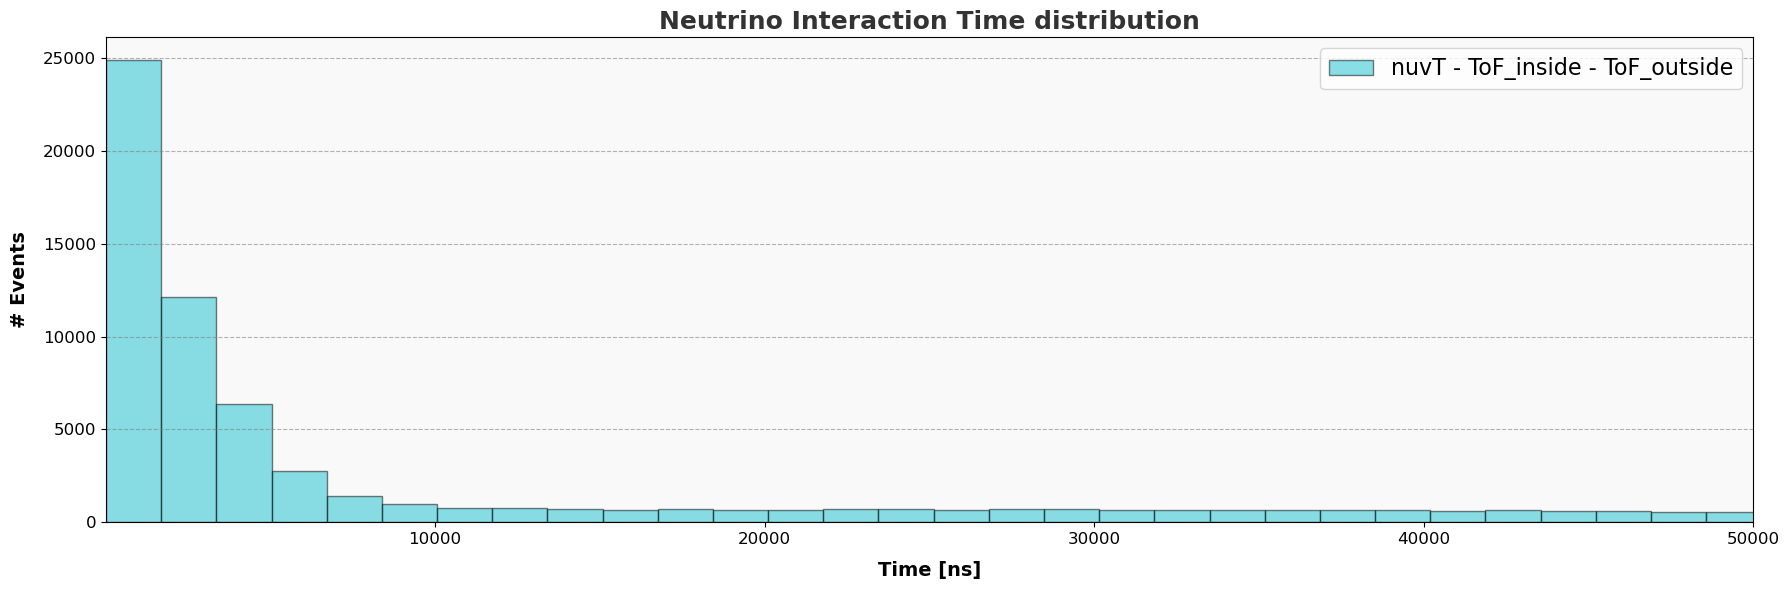

In [54]:
import matplotlib.pyplot as plt
import numpy as np
import awkward as ak

# Assuming hit_nuvT, ToF_outside_set0, and ToF_inside are defined awkward arrays
# Calculate the difference and flatten it
#difference = np.mod(ak.flatten(nuvT - ToF_inside - ToF_outside), 19)


# Calculate the standard deviation
#std_dev = np.std(nuvT)
#std_dev2 = np.std(nuvT_c + ToF_outside)

# Set up the plot
plt.figure(figsize=(18, 6))
#plt.hist(nuvT, bins=600, color='#ff7f0e', edgecolor='black', alpha=0.8, label='nuvT')
plt.hist(ak.flatten(flash_total_pe), bins=200, color='#17becf', edgecolor='black', alpha=0.5, label='nuvT - ToF_inside - ToF_outside')

# Customize the title and labels
plt.title('Neutrino Interaction Time distribution', fontsize=18, fontweight='bold', color='#333333')
plt.xlabel('Time [ns]', fontsize=14, labelpad=10, fontweight='bold')
plt.ylabel('# Events', fontsize=14, labelpad=10, fontweight='bold')

# Set axis limits
plt.xlim(10,50000)
plt.ylim(0, None)

# Enhance the grid and axis appearance
plt.grid(axis='y', linestyle='--', alpha=0.6, color='gray')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add a light background color for the plot area to add contrast
plt.gca().set_facecolor('#f9f9f9')

# Add a legend
plt.legend(fontsize=16)

# Show the plot
plt.tight_layout()
plt.show()

**Sin ajustar ToF (ver posteriormente)**

In [42]:
#y = np.column_stack((nuvT_c, dEpromx_f, dEpromy_f, dEpromz_f))
y = ak.to_numpy(nuvT)

In [43]:
print("y:", y)
print("y.shape:", y.shape)

y: [[1832.7022871 ]
 [1851.59823681]
 [ 519.95393046]
 ...
 [ 889.15791959]
 [1346.44396473]
 [ 642.10002491]]
y.shape: (29007, 1)


In [44]:
import awkward as ak
import numpy as np

# Determinar la longitud máxima
target_length = max(len(arr) for arr in flash_time)

# Rellenar las secuencias con `None` hasta la longitud máxima
flash_time_padded = ak.pad_none(flash_time, target=target_length, axis=-1)
flash_total_pe_padded = ak.pad_none(flash_total_pe, target=target_length, axis=-1)
flash_tpc_padded = ak.pad_none(flash_tpc, target=target_length, axis=-1)

# Ver los arrays rellenos
print(flash_time_padded)
print(flash_total_pe_padded)
print(flash_tpc_padded)

[[1.83, 1.89, None, None], [1.85, ..., None], ..., [0.501, 0.497, 0.58, 0.52]]
[[4.25e+04, 2.39e+03, None, None], [...], ..., [2.54e+04, 2.87e+03, 952, 111]]
[[0, 2, None, None], [0, 2, None, None], ..., [0, 1, ..., None], [0, 1, 2, 3]]


In [45]:
# Convertir a arrays de NumPy
flash_time_np = ak.to_numpy(flash_time_padded)
flash_total_pe_np = ak.to_numpy(flash_total_pe_padded)
flash_tpc_np = ak.to_numpy(flash_tpc_padded)

In [46]:
import numpy as np

# Replace '--' with 0 in your NumPy array
flash_time_array = np.array(flash_time_np, dtype=object)  # Assuming `flash_time_np` contains the data
flash_time_array = flash_time_array.astype(float)  # Convert to float
flash_time_array = np.nan_to_num(flash_time_array, nan=0.0)

flash_total_pe_array = np.array(flash_total_pe_np, dtype=object)  # Assuming `flash_time_np` contains the data
flash_total_pe_array = flash_total_pe_array.astype(float)  # Convert to float
flash_total_pe_array = np.nan_to_num(flash_total_pe_array, nan=0.0)

flash_tpc_array = np.array(flash_tpc_np, dtype=object)  # Assuming `flash_time_np` contains the data
flash_tpc_array = flash_tpc_array.astype(float)  # Convert to float
flash_tpc_array = np.nan_to_num(flash_tpc_array, nan=0.0)

In [47]:
print(flash_time_array.shape)
print(flash_total_pe_array.shape)
print(flash_tpc_array.shape)

(29007, 4)
(29007, 4)
(29007, 4)


In [48]:
X = np.stack((flash_time_array, flash_total_pe_array,flash_tpc_array), axis=2)
print(X.shape)

(29007, 4, 3)


In [49]:
test_size = int(np.floor(0.30*np.shape(y)[0]) )
print(test_size)

X_train, X_test = X[:-test_size], X[-test_size:]
print('X_train dim.:',X_train.shape)
print('X_test dim.:', X_test.shape)
y_train, y_test = y[:-test_size], y[-test_size:]
print('y_train dim.:',y_train.shape)
print('y_test dim.:', y_test.shape)

8702
X_train dim.: (20305, 4, 3)
X_test dim.: (8702, 4, 3)
y_train dim.: (20305, 1)
y_test dim.: (8702, 1)


**Model LSTM**

In [35]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Masking, LSTM, Dense, Flatten, BatchNormalization, Dropout

model = Sequential([
    Masking(mask_value=0, input_shape=(4, 3)),
    LSTM(10, return_sequences=True),  # LSTM con secuencias intermedias
    LSTM(10, return_sequences=False),  # LSTM final
    BatchNormalization(),  # Normalización para estabilizar el entrenamiento
    Dropout(0.2),  # Dropout para prevenir overfitting
    Dense(20, activation='relu'),  # Capa densa intermedia
    Dense(1)  # Capa de salida escalar
])

model.compile(optimizer='adam', loss='mse')

print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_2 (Masking)         (None, 4, 3)              0         
                                                                 
 lstm_4 (LSTM)               (None, 4, 10)             560       
                                                                 
 lstm_5 (LSTM)               (None, 10)                840       
                                                                 
 batch_normalization_2 (Batc  (None, 10)               40        
 hNormalization)                                                 
                                                                 
 dropout_2 (Dropout)         (None, 10)                0         
                                                                 
 dense_4 (Dense)             (None, 20)                220       
                                                      

**Model Fully Connected**

In [50]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Input

# Dimensiones de entrada
n_samples = 29007  # Número de eventos
n_timesteps = 4    # Número de elementos por evento
n_features = 3     # Número de características por elemento

# Arquitectura del modelo
model = Sequential([
    # Capa de entrada: Aplanado de (4, 3) a 12
    Input(shape=(n_timesteps, n_features)),
    Flatten(),
    # Capas densas
    Dense(128, activation='relu'),  # Primera capa oculta con 128 neuronas
    Dense(64, activation='relu'),   # Segunda capa oculta con 64 neuronas
    Dense(32, activation='relu'),   # Tercera capa oculta con 32 neuronas
    
    # Capa de salida
    Dense(1, activation='linear')  # Salida escalar para regresión
])

# Compilación del modelo
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Resumen del modelo
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 12)                0         
                                                                 
 dense (Dense)               (None, 128)               1664      
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 12,033
Trainable params: 12,033
Non-trainable params: 0
_________________________________________________________________


**Training**

In [51]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping, ReduceLROnPlateau

# Define the callbacks
weights_file = "/tmp/weights_nuvT.hdf5.keras"

checkpoint = ModelCheckpoint(
weights_file, monitor='val_loss', verbose=0, save_best_only=True, mode='min'
)
early_stopping = EarlyStopping(
monitor='val_loss', patience=8, restore_best_weights=True
)
reduce_lr = ReduceLROnPlateau(
monitor='val_loss', factor=0.5, patience=4, min_lr=1e-6, verbose=1
)

# Add all callbacks to the list
callbacks = [checkpoint, early_stopping, reduce_lr]


model.fit(X_train, 
        y_train, 
        epochs=30, 
        batch_size=32, 
        callbacks=callbacks,
        validation_data=(X_test, y_test),
        verbose=1)

Epoch 1/30
635/635 [==============================] - 3s 4ms/step - loss: 231142976389120.0000 - mae: 1759036.8750 - val_loss: 2486942.5000 - val_mae: 1006.3854 - lr: 0.0010
Epoch 2/30
635/635 [==============================] - 2s 3ms/step - loss: 3441102.0000 - mae: 1225.6584 - val_loss: 2079372.3750 - val_mae: 989.8456 - lr: 0.0010
Epoch 3/30
635/635 [==============================] - 2s 3ms/step - loss: 3401015.5000 - mae: 1294.5447 - val_loss: 2422590.5000 - val_mae: 1137.1331 - lr: 0.0010
Epoch 4/30
635/635 [==============================] - 2s 3ms/step - loss: 484632416.0000 - mae: 8115.1992 - val_loss: 208740704.0000 - val_mae: 5215.8433 - lr: 0.0010
Epoch 5/30
635/635 [==============================] - 2s 3ms/step - loss: 5041298079744.0000 - mae: 673148.5625 - val_loss: 203182440448.0000 - val_mae: 143657.5156 - lr: 0.0010
Epoch 6/30
620/635 [============================>.] - ETA: 0s - loss: 33312137216.0000 - mae: 39637.6797
Epoch 00006: ReduceLROnPlateau reducing learning ra

In [52]:
# Load the best weights
model.load_weights(weights_file)

# Predict on new data (X_test in this example)
y_pred = model.predict(X_test)
print("Predictions:", y_pred)
print(y_pred.shape)

Predictions: [[ 207.49306]
 [1035.993  ]
 [ 797.1255 ]
 ...
 [2477.9932 ]
 [2428.4932 ]
 [ 349.75092]]
(8702, 1)


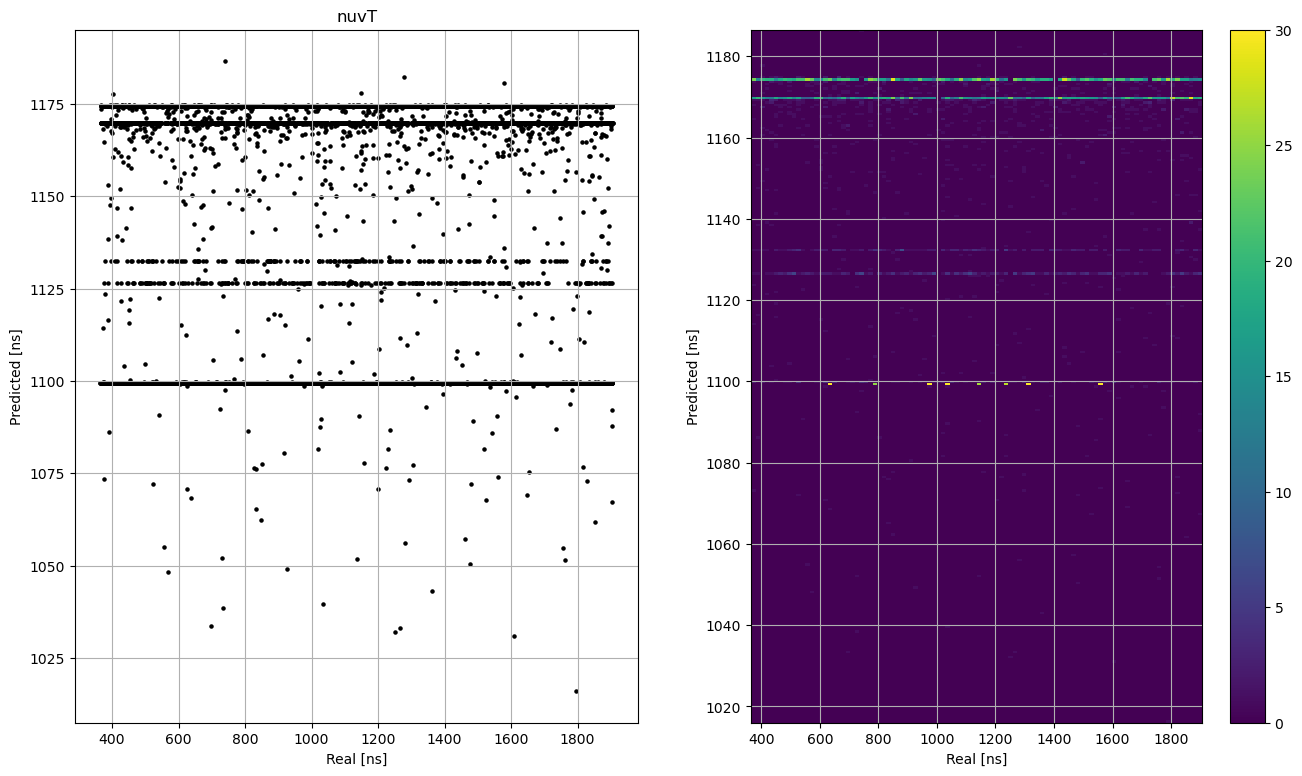

In [39]:
fig, axs = plt.subplots(1,2,figsize=(16,9))

axs[0].scatter(y_test[:,0], y_pred[:,0], color="black",s=5)
axs[0].grid()

#axs[0].plot([0,20],[0,20],color="r")
axs[0].title.set_text('nuvT')
#axs[0].set_xlim([0,20])
#axs[0].set_ylim([0,20])
axs[0].set_ylabel('Predicted [ns]')
axs[0].set_xlabel('Real [ns]')

im0 = axs[1].hist2d(y_test[:,0], y_pred[:,0].flatten(), bins=(100, 300), cmap='viridis', cmax=30)
fig.colorbar(im0[3], ax=axs[1])
axs[1].grid()

#axs[1].plot([0,20],[0,20],'r')
#axs[1].set_xlim([0,20])
#axs[1].set_ylim([0,20])
axs[1].set_ylabel('Predicted [ns]')
axs[1].set_xlabel('Real [ns]')
axs[1].set_facecolor('#440154')
